<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opendatasets
!pip install geopy
!pip install folium
!pip install -U pymoo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.8 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=5bdca30efb0a488bdb99f7a4bcd36664c1a2c95c20d8ad59b165f923c2a258a9
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [53]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 1000)

In [ ]:
hotel = pd.read_csv('/content/drive/MyDrive/Shiraz/hotel.csv')
historic =  pd.read_csv('/content/drive/MyDrive/Shiraz/historic.csv')
museum = pd.read_csv('/content/drive/MyDrive/Shiraz/museum.csv')
park = pd.read_csv('/content/drive/MyDrive/Shiraz/park.csv')
resturant = pd.read_csv('/content/drive/MyDrive/Shiraz/restaurant.csv')
tag = pd.read_csv('/content/drive/MyDrive/Shiraz/tag.csv')




In [ ]:
preference = pd.read_csv('/content/drive/MyDrive/Shiraz/preference.csv')
group = pd.read_csv('/content/drive/MyDrive/Shiraz/group.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Shiraz/group.csv'

In [ ]:
tag

,Unnamed: 0,Id,Title,Title:Fn
0,0,1,Historical,مکان‌های تاریخی مانند آثار باستانی و معماری قد...
1,1,2,Recreational,مکان‌های تفریحی مانند پارک‌ها، شهربازی‌ها و مر...
2,2,3,Natural,جاذبه‌های طبیعی مانند کوه‌ها، جنگل‌ها، دریاها ...
3,3,4,Adventure,مکان‌های ماجراجویانه (مانند کوه‌نوردی، صخره‌نو...
4,4,5,Religious,مکان‌های مذهبی (مانند کلیساها، مساجد، معابد).
5,5,6,Health/Thermal,مکان‌های سلامت و درمانی مانند چشمه‌های آب گرم
6,6,7,Resort,استراحتگاه.
7,7,8,Artistic,مکان‌هایی هنری مانند گالری‌ها، موزه‌ها و مناظر...
8,8,9,Photography,مکان های مناسب عکاسی مانند گالری، موزه ها و م...
9,9,10,Cultural,مکان‌هایی که فرهنگ و هنر یک منطقه را نمایش می‌...


In [ ]:
group = pd.DataFrame(columns=["Id", "StartData", "EndDate", "Budget"])

In [ ]:
preference = pd.DataFrame(columns=["Id", "GroupId", "UserId", "Preference"])

In [ ]:
preference.to_csv('/content/drive/MyDrive/Shiraz/preference.csv')

In [ ]:
preference

,Id,GroupId,UserId,Preference


In [ ]:
tag = pd.DataFrame(columns=["Id", "Title", "Title:Fn"])

In [ ]:
data = [{
    "Id": 1,
    "GroupId": 1,
    "UserId": 1,
    "Preference": {"historic" : 3, "Resort": 1, "Natural": 5}
}]

In [ ]:
preference = pd.DataFrame(data)
preference.to_csv('/content/drive/MyDrive/Shiraz/preference.csv')

In [ ]:
grouped = preference.groupby('GroupId')

In [ ]:

for name, group in grouped:
  if (len(group) > 1):
    preferenceList = {}
    for preference in group['Preference']:
      for p in preference:
        if(p not in preferenceList):
          preferenceList[p] = preference[p]
        else:
          preferenceList[p] += preference[p]
    for preference in preferenceList:
      preferenceList[preference] = preferenceList[preference] / len(group)
  else:
      preferenceList = group['Preference']

preferenceList



,Preference
3,"{'Cultural': 5, 'Historical': 3}"


In [ ]:
data = [{
    "Id" : 1,
    "StartData" : "2012-02-02",
    "EndDate" : "2012-02-02",
    "ComfortRatio" : 10,
    "Budget" : 10000
}]


In [ ]:
group = pd.DataFrame(data)

In [ ]:
group.to_csv('/content/drive/MyDrive/Shiraz/group.csv')

In [ ]:
locations = pd.concat([hotel, historic, museum, park, resturant])
locations["Id"] = [i for i in range(len(locations))]

In [54]:
locations = pd.read_csv('/content/drive/MyDrive/Shiraz/locations.csv')

In [56]:
locations["Id"] = [i for i in range(len(locations))]

In [57]:
import random
locations["Stars"] = [random.randint(1, 5) for i in range(len(locations))]
locations["Price"] = [random.randint(10, 200) for i in range(len(locations))]

Initial Population:
[[  14  722 1061 ...  444  523  555]
 [  14   75  651 ... 1177 1083  704]
 [  13  946  290 ...  855   44    0]
 ...
 [  10 1198  820 ...    0    0    0]
 [  14    2  835 ... 1053  407 1079]
 [  14  900  229 ...  248  585  353]]
---------------------
route:[  14  722 1061  351   73 1085  701  591  860 1121  766  674  444  523
  555]
route:[  14   75  651  111    2 1051  668  346  910 1055  402  863 1177 1083
  704]
route:[  13  946  290  124   91 1095  822  126   31 1188  848 1195  855   44
    0]
route:[   8   53  454  259    6 1087  195  247 1178    0    0    0    0    0
    0]
route:[  13 1061  759 1111  611  109  595  891 1117  789  892  272 1104  922
    0]
route:[   9   84 1138  409  630  232  968 1161  651  111    0    0    0    0
    0]
route:[   5 1088  887 1161  206  915    0    0    0    0    0    0    0    0
    0]
route:[  13  972  741 1089  738  569 1158   36  154  824  663 1186  483  252
    0]
route:[   8  533 1053   47  331  278  178  416  595    0  

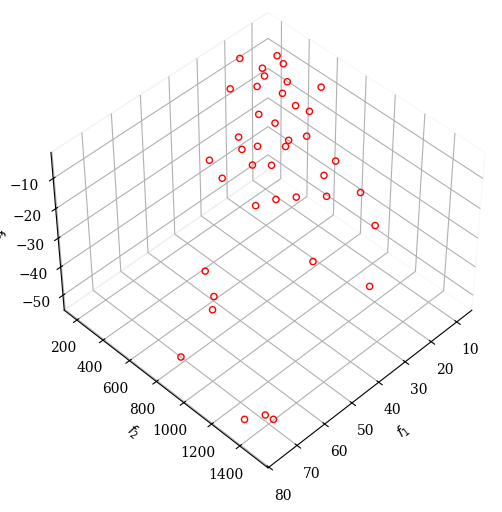

In [92]:
from os import replace
import random
import numpy as np
import folium

from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter
from pymoo.core.mutation import Mutation


def repairSolution(solution):
   solution = [int(row) for row in solution]
   return solution


def isValidSolution(solution):
   solution = [int(row) for row in solution]
   return True




def createSolution(n_var):
    sample = [0 for _ in range(n_var)]

    rand = random.randint(3, n_var-1)
    sample[0] = rand

    for i in range(1, rand+1):
      location = locations.sample(n=1)
      sample[i] = location["Id"].values[0]

    return sample


class ValidatePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = []  # نگه‌داشتن تاریخچه جمعیت‌های معتبر

    def notify(self, algorithm):
        # ترکیب والدین و فرزندان
        combined_population = np.vstack([algorithm.pop.get("X"), algorithm.off.get("X")])

        # اصلاح جمعیت جدید
        new_population = np.zeros_like(combined_population)  # جمعیت جدید اصلاح‌شده

        for i in range(len(combined_population)):
            # اصلاح هر فرد از جمعیت
            individual = combined_population[i]

            # اصلاح فرد با استفاده از روش‌های مورد نظر (مثلاً ایجاد یک راه‌حل معتبر)
            # فرض کنید تابع اصلاحی createValidSolution این کار را انجام می‌دهد
            individual = self.repair_individual(individual)

            # اصلاح فرد در جمعیت جدید
            new_population[i] = individual
        F = np.zeros((new_population.shape[0], algorithm.problem.n_obj))
        algorithm.problem._evaluate(new_population, out={"F": F})




        # به روز رسانی جمعیت با جمعیت اصلاح‌شده
        # اطمینان از هم‌خوانی اندازه جمعیت
        if new_population.shape[0] == algorithm.pop.size:
            algorithm.pop.set("X", new_population)
        else:
            # اگر تعداد تغییر کرده، تعداد جمعیت را مطابق با نیاز تنظیم کنید
            algorithm.pop.set("X", new_population[:algorithm.pop.size])


    def repair_individual(self, individual):
        if(isValidSolution(individual) == False):
            individual = repairSolution(individual)
        return individual




class CustomMutation(Mutation):
    def _do(self, problem, X, **kwargs):
      return X

class TournamentSelection(Selection):
    def __init__(self, tournament_size=2):
        super().__init__()
        self.tournament_size = tournament_size

    def _do(self, problem, pop, n_select, n_parents=1, **kwargs):
        selected = np.full((n_select, n_parents), -1, dtype=int)

        for i in range(n_select):
            for j in range(n_parents):
                # انتخاب کاندیداها به صورت تصادفی
                candidates = np.random.choice(len(pop), self.tournament_size, replace=False)

                # مقایسه کاندیداها بر اساس fitness (مقدار F)
                best = candidates[np.argmin([pop[c].F[0] for c in candidates])]
                selected[i, j] = best

        return selected




class CustomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)


        for row in range(len(samples)):
            samples[row] = createSolution(n_var)

        print("Initial Population:")
        print(samples)
        print('---------------------')

        return samples


def getObjective(routes):
    total_distance = []
    total_cost = []
    total_rate = []


    for route in routes:


        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0

        print(f"route:{route}")
        # calculate distance
        for i in range(1, route[0]):
            start, end = int(route[i]), int(route[i + 1])

            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]

            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]

            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)


        # caculate rate
        for i in range(0, route[0]):
          node = locations[locations["Id"] == route[i]]
          rate -=  node["Stars"].values[0]


        # caculate cost
        for i in range(0, route[0]):
            start = locations[locations["Id"] == route[i]]
            cost += start["Price"].values[0]

        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(rate)

    return (total_distance, total_cost, total_rate)


# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self, n_var):


      super().__init__(n_var=n_var,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=len(locations) - 1,
                         type_var=int)



    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x)

        out["F"] = np.column_stack([total_distance, total_cost, total_rate])






class CustomeCrossover(Crossover):
    def __init__(self):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)

        for k in range(n_matings):
            while True:
                # انتخاب والدین
                parent1 = [int(item) for item in X[0, k]]
                parent2 = [int(item) for item in X[1, k]]


                point1 = math.ceil(parent1[0] / 2) + 1
                point2 = math.ceil(parent2[0] / 2) + 1





                count1 = len(parent1[1:point1]) + len(parent2[point2:parent2[0]+1])
                count2 = len(parent2[1:point2]) + len(parent1[point1:parent1[0]+1])

                child1 = np.hstack([count1 , parent1[1:point1], parent2[point2:parent2[0]+1], np.full((n_var - count1) - 1, 0)])
                child2 = np.hstack([count2 , parent2[1:point2], parent1[point1:parent1[0]+1], np.full((n_var - count2) - 1 , 0)])


                print(f"parent1: {parent1}")
                print(f"parent2: {parent2}")
                print(f"child1:  {child1}")
                print(f"child2:  {child2}")
                print("--------------")
                break


            # ذخیره فرزندان
            Y[0, k] = child1
            Y[1, k] = child2

        return Y





selection  = TournamentSelection(tournament_size=3)


algorithm = NSGA2(pop_size=100,
                  sampling=CustomSampling(),
                  crossover=CustomeCrossover(),
                  # callback=ValidatePopulationCallback(),
                  mutation=CustomMutation(),
                  # selection=selection
                  )



preference = {"historic": 5}



problem = HotelRouteProblem(n_var=15)
res = minimize(problem,
               algorithm,
               termination=('n_gen', 3),
               verbose=True)



best_index = np.argmin(res.F[:, 2])
best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]
best_rate = res.F[best_index, 2]

print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)
print("Best rate:", abs(best_rate))

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()



In [93]:
import folium

# ایجاد یک نقشه در مرکز اولین مکان
map_center = [locations["Longitude"].mean(), locations["Latitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

for key in best_route:
    location = locations[locations["Id"] == key]

    folium.Marker(
        location=[location["Longitude"].values[0], location["Latitude"].values[0]],
        popup=locations["name"].values[0],
        tooltip=f"{locations['name'].values[0]}",
    ).add_to(mymap)


mymap




الگوریتم فازی - برای هر هتل سه مقدار بدبینانه،خوش بینانه و متوسط رو در نظر می گیریم

In [ ]:
import requests

# API Key خود را اینجا وارد کنید
API_KEY = '3k_wLMNf6CwujHWVLSLnoZFLnuDLAkzBrLxfZU9GT5cG2tkgngTk3YcAD80AUOTE665dznOmk1LXWbVHFvtBehmk-ao0Dnzo7urxabgbhvXWcDzWSRNWfvoXm-cDZ3Yx'

# URL پایه برای درخواست‌ها
url = 'https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA'

# سربرگ‌ها (Headers) با کلید API
headers = {
    'Authorization': f'Bearer {API_KEY}',
}

# پارامترهای جستجو (می‌توانید موقعیت جغرافیایی، نوع کسب‌وکار و غیره را مشخص کنید)
params = {
    # 'term': 'hotels',   # نوع کسب‌وکار
    'location': 'New York',  # مکان
    'limit': 5               # تعداد نتایج
}

# ارسال درخواست به Yelp API
response = requests.get(url, headers=headers, params=params)

# بررسی وضعیت درخواست و چاپ نتایج
if response.status_code == 200:
    data = response.json()
    businesses = data.get('businesses')
    print(businesses)
    # for business in businesses:
    #     print(f"Name: {business['name']}, Rating: {business['rating']}, Address: {', '.join(business['location']['display_address'])}")
else:
    print(f"Error: {response.status_code}, {response.text}")


In [50]:
import numpy as np
import math

parent1 = [6, 1, 2, 3, 4, 5, 10, -1, -1]
parent2 = [4, 6, 7, 8, 9, -1, -1, -1, -1]

point1 = math.ceil(parent1[0] / 2) + 1
point2 = math.ceil(parent2[0] / 2) + 1





count1 = len(parent1[1:point1]) + len(parent2[point2:parent2[0]+1])
count2 = len(parent2[1:point2]) + len(parent1[point1:parent1[0]+1])
max = 9
child1 = np.hstack([count1 , parent1[1:point1], parent2[point2:parent2[0]+1], np.full(max - count1, -1)])
child2 = np.hstack([count2 , parent2[1:point2], parent1[point1:parent1[0]+1], np.full(max - count2, -1)])
print(child1)
print(child2)




[ 5  1  2  3  8  9 -1 -1 -1 -1]
[ 5  6  7  4  5 10 -1 -1 -1 -1]
